## Other things we can do with time series

+ Classification—Assign one or more categorical labels to a timeseries. For instance, given the timeseries of the activity of a visitor on a website, classify whether the visitor is a bot or a human.
+ Event detection—Identify the occurrence of a specific expected event within a continuous data stream. A particularly useful application is “hotword detection,” where a model monitors an audio stream and detects utterances like “Ok Google” or “Hey Alexa.”
+ Anomaly detection—Detect anything unusual happening within a continuous datastream. Unusual activity on your corporate network? Might be an attacker. Unusual readings on a manufacturing line? Time for a human to go take a look. Anomaly detection is typically done via unsupervised learning, because you often don’t know what kind of anomaly you’re looking for, so you can’t train on specific anomaly examples. 

In [1]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
  
with open(fname) as f:
    data = f.read()
  
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:] 
print(header) 
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
import pandas as pd
df = pd.read_csv("jena_climate_2009_2016.csv")

In [3]:
time = pd.to_datetime(df['Date Time'])
time

0        2009-01-01 00:10:00
1        2009-01-01 00:20:00
2        2009-01-01 00:30:00
3        2009-01-01 00:40:00
4        2009-01-01 00:50:00
                 ...        
420446   2016-12-31 23:20:00
420447   2016-12-31 23:30:00
420448   2016-12-31 23:40:00
420449   2016-12-31 23:50:00
420450   2017-01-01 00:00:00
Name: Date Time, Length: 420451, dtype: datetime64[ns]

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1)) 
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

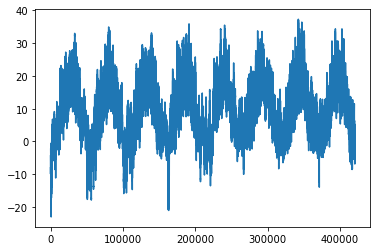

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

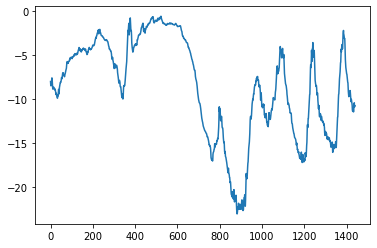

In [6]:
plt.plot(range(1440), temperature[:1440])

## Preparing the data

+ given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?
+ the data is already numerical, so you don’t need to do any vectorization

+ But each timeseries in the data is on a different scale (for example, atmospheric pressure, measured in mbar, is around 1,000, while H2OC, measured in millimoles per mole, is around 3). We’ll normalize each timeseries independently so that they all take small values on a similar scale. We’re going to use the first 210,225 timesteps as training data, so we’ll compute the mean and standard deviation only on this fraction of the data.


In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

### timeseries_dataset_from_array

Understanding timeseries_dataset_from_array()

To understand what timeseries_dataset_from_array() does, let’s look at a simple example. The general idea is that you provide an array of timeseries data (the data argument), and timeseries_dataset_from_array() gives you windows extracted from the original timeseries (we’ll call them “sequences”).

For example, if you use data = [0 1 2 3 4 5 6] and sequence_length=3, then timeseries_dataset_from_array() will generate the following samples: [0 1 2], [1 2 3], [2 3 4], [3 4 5], [4 5 6].

You can also pass a targets argument (an array) to timeseries_dataset_ from_array(). The first entry of the targets array should match the desired target for the first sequence that will be generated from the data array. So if you’re doing timeseries forecasting, targets should be the same array as data, offset by some amount.

For instance, with data = [0 1 2 3 4 5 6 ...] and sequence_length=3, you could create a dataset to predict the next step in the series by passing targets = [3 4 5 6 ...]. Let’s try it:



In [9]:
import numpy as np 
from tensorflow import keras

In [10]:
int_sequence = np.arange(10)


## Sampling the data

Use timeseries_dataset_from_array to create extract train, test, validation datasets from the data

+ sampling_rate = 6—Observations will be sampled at one data point per hour: we will only keep one data point out of 6.
+ sequence_length = 120—Observations will go back 5 days (120 hours).
+ delay = sampling_rate * (sequence_length + 24 - 1)—The target for a sequence will be the temperature 24 hours after the end of the sequence. 

In [11]:
sampling_rate = 6 
sequence_length = 120 
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256 
  
train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
  
val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
  
test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

2021-11-16 12:39:30.674715: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


+ Each dataset yields a tuple (samples, targets), where samples is a batch of 256 samples, each containing 120 consecutive hours of input data, and targets is the corresponding array of 256 target temperatures. 

+ Note that the samples are randomly shuffled, so two consecutive sequences in a batch (like samples[0] and samples[1]) aren’t necessarily temporally close. 

In [12]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break


2021-11-16 12:39:30.782597: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-16 12:39:30.803108: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3498265000 Hz


samples shape: (256, 120, 14)
targets shape: (256,)


## Predict last value

In [13]:
def evaluate_naive_method(dataset):
    total_abs_err = 0. 
    samples_seen = 0 
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen
  
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}") 
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


## basic machine learning model

+ a fully connected model that starts by flattening the data and then runs it through two Dense layers. 
+ Note the lack of an activation function on the last Dense layer, which is typical for a regression problem. 
+ We use mean squared error (MSE) as the loss, rather than MAE, because unlike MAE, it’s smooth around zero, which is a useful property for gradient descent. We will monitor MAE by adding it as a metric in compile().

In [14]:
from tensorflow import keras 
from tensorflow.keras import layers
  
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
] 
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 11s 13ms/step - loss: 24.7891 - mae: 3.7495 - val_loss: 11.4787 - val_mae: 2.6734
Epoch 2/10
819/819 [==============================] - 10s 12ms/step - loss: 10.1042 - mae: 2.5086 - val_loss: 10.6664 - val_mae: 2.5728
Epoch 3/10
819/819 [==============================] - 10s 13ms/step - loss: 9.0713 - mae: 2.3776 - val_loss: 10.6288 - val_mae: 2.5789
Epoch 4/10
819/819 [==============================] - 10s 12ms/step - loss: 8.4636 - mae: 2.2968 - val_loss: 11.2629 - val_mae: 2.6530
Epoch 5/10
819/819 [==============================] - 10s 13ms/step - loss: 8.0158 - mae: 2.2360 - val_loss: 11.4644 - val_mae: 2.6965
Epoch 6/10
819/819 [==============================] - 10s 12ms/step - loss: 7.6812 - mae: 2.1882 - val_loss: 10.7714 - val_mae: 2.6077
Epoch 7/10
819/819 [==============================] - 11s 13ms/step - loss: 7.4879 - mae: 2.1639 - val_loss: 11.4608 - val_mae: 2.6812
Epoch 8/10
819/819 [==============================] -

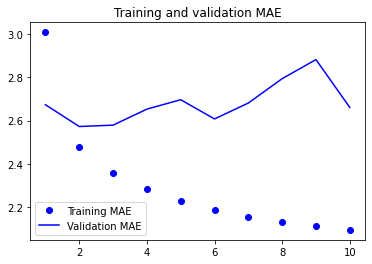

In [15]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

why didnt we find the common sense solution? Bcs the problem is not convex.

## try a 1D convolutional model

This model is similar to a moving average.

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 23s 27ms/step - loss: 29.3377 - mae: 4.1735 - val_loss: 14.5494 - val_mae: 3.0251
Epoch 2/10
819/819 [==============================] - 22s 27ms/step - loss: 15.6415 - mae: 3.1318 - val_loss: 14.5585 - val_mae: 3.0149
Epoch 3/10
819/819 [==============================] - 23s 28ms/step - loss: 14.0729 - mae: 2.9632 - val_loss: 14.5365 - val_mae: 2.9772
Epoch 4/10
819/819 [==============================] - 22s 27ms/step - loss: 13.0707 - mae: 2.8519 - val_loss: 14.2004 - val_mae: 2.9454
Epoch 5/10
819/819 [==============================] - 23s 27ms/step - loss: 12.4138 - mae: 2.7789 - val_loss: 15.2701 - val_mae: 3.0483
Epoch 6/10
819/819 [==============================] - 22s 27ms/step - loss: 11.8880 - mae: 2.7215 - val_loss: 15.7241 - val_mae: 3.0857
Epoch 7/10
819/819 [==============================] - 22s 27ms/step - loss: 11.4986 - mae: 2.6807 - val_loss: 15.6766 - val_mae: 3.0968
Epoch 8/10
819/819 [============================

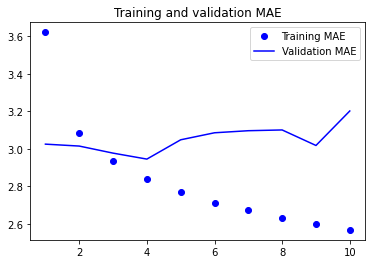

In [17]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

As it turns out, this model performs even worse than the densely connected one, only achieving a validation MAE of about 2.9 degrees, far from the common-sense baseline. What went wrong here? Two things:

+ First, weather data doesn’t quite respect the translation invariance assumption. While the data does feature daily cycles, data from a morning follows different properties than data from an evening or from the middle of the night. Weather data is only translation-invariant for a very specific timescale.
+ Second, order in our data matters—a lot. The recent past is far more informative for predicting the next day’s temperature than data from five days ago. A 1D convnet is not able to leverage this fact. In particular, our max pooling and global average pooling layers are largely destroying order information. 

# A first recurrent baseline

+ The densely connected approach first flattened the timeseries, which removed the notion of time from the input data. 
+ The convolutional approach treated every segment of the data in the same way, even applying pooling, which destroyed order information. Let’s instead look at the data as what it is: a sequence, where causality and order matter.

### Simple LSTM examplem

In [18]:
import tensorflow.keras.layers

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
type(inputs)

tensorflow.python.keras.engine.keras_tensor.KerasTensor

In [20]:
x = layers.LSTM(16)

In [21]:
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

TypeError: Inputs to a layer should be tensors. Got: <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7f4bcc07a790>